##   Fit5226 Assignment1  
###   student id: 34450955  student: Yiran Wang
This project implements a tabular Q-learning system for a multi-agent delivery task in a 5x5 grid environment, 
where agents must pick up an item from location A and deliver it to location B without colliding with each other. 
The environment simulates Central Clock synchronization and uses Neighbouring Opposite Direction Sensor to detect threats.
The implementation supports:
    4 agents acting in turn,
    A shared, fixed-size grid,
    Tabular Q-table for state-action value storage,
    Epsilon-greedy policy for exploration vs exploitation,
    Reward shaping and threat awareness to promote coordination.
    
Contract: Central Clock + Neighbouring Opposite Direction Sensor

Rewards: Step=-0.5, Pickup=+50, Delivery=+150, Collision=-200, Rightdirection=+2

In [25]:
import numpy as np
import random
import time
import matplotlib.pyplot as plt

# === Constants ===
ACTIONS = ['UP', 'DOWN', 'LEFT', 'RIGHT']
DELTA = {
    'UP': (-1, 0),
    'DOWN': (1, 0),
    'LEFT': (0, -1),
    'RIGHT': (0, 1)
}
GRID_SIZE = 5 
NUM_AGENTS = 4
COLLISION_BUCKET = 10000

##     
 QTableAgent class implements a tabular Q-learning agent that maintains a discrete Q-value table 
 for all possible environment states and agent actions.
 Each agent uses the same instance of the Q-table, which encodes knowledge about state-action utility 
 and is updated via the Q-learning update rule. The agent acts using an ε-greedy policy that balances 
 exploration and exploitation.
    
    parameters:
    ·lr:	Learning rate controlling update aggressiveness (default: 0.2)
    ·gamma:Discount factor for future rewards (default: 0.92)
    ·epsilon:	Initial exploration rate (default: 1.0)
    ·epsilon_min:	Lower bound for exploration rate (default: 0.08)
    ·epsilon_decay:	Decay factor applied to epsilon after each step (default: 0.999996996)
    
    
Q value update applies: Q(s,a)←Q(s,a)+α⋅[r+γ⋅ maxQ(s ′,a ′)−Q(s,a)]
Encourages convergence to optimal policies through incremental updates.


In this stage, I tried various of combinations of parameters values, 
    these are the values which support a best performance I've tried. The highest success rate is 71.11%
However, if the agent is trained 10million steps, with lr=0.3, gamma=0.9, epsilon=1.0, epsilon_min=0.08, epsilon_decay=0.99999968,
    the performance would be 79.83% instead.

In [26]:
# === Q-Table Agent ===
class QTableAgent:
    def __init__(self, lr=0.2, gamma=0.92, epsilon=1.0, epsilon_min=0.08, epsilon_decay=0.999996996):
        self.lr = lr
        self.gamma = gamma
        self.epsilon = epsilon
        self.epsilon_min = epsilon_min
        self.epsilon_decay = epsilon_decay
        '''
        The Q-table is implemented as a 12-dimensional NumPy array, capturing the state space and available actions:
        Q[agentx, agenty, Ax, Ay, Bx, By, has_item, up, down, left, right, action]
        ·agentx, agenty: agent’s position
        ·Ax, Ay: position of item A
        ·Bx, By: position of delivery B
        ·has_item: whether the agent is carrying the item (0 or 1)
        ·up/down/left/right: binary threat sensor values (1 = threat)
        ·action: index of chosen action among ['UP', 'DOWN', 'LEFT', 'RIGHT']
        
        '''
        self.Q = np.zeros((GRID_SIZE, GRID_SIZE, GRID_SIZE, GRID_SIZE, GRID_SIZE, GRID_SIZE, 2, 2, 2, 2, 2, len(ACTIONS)))
        # initialize q_table, each value should be 0 at beginning
        self.visited_states = set()  # track visited states

    def choose_action(self, state):
        # Implements ε-greedy exploration:
        state_key = tuple(state)[:11]  # exclude action
        self.visited_states.add(state_key)
        
        
        if random.random() < self.epsilon:
        # if random number is less than epsilon, agent would take a random action to explore
            return random.randint(0, len(ACTIONS) - 1)
        return int(np.argmax(self.Q[state]))

    def update_Q(self, state, action, next_state, reward):
        current_q = self.Q[state + (action,)]
        target_q = np.max(self.Q[next_state])
        self.Q[state + (action,)] = current_q + self.lr * (reward + self.gamma * target_q - current_q)



### Environment: Multi-Agent Grid World
This class defines a 5×5 discrete grid environment simulating a multi-agent delivery task. It includes item pickup at location A, item drop-off at location B, and potential threats from nearby agents moving in opposite directions.

    Component:
    ·size:	Size of the grid (default: 5×5)
    ·A_pos, B_pos:	Randomly generated pickup and delivery locations
    ·agent_coords:	Current position of each agent
    ·item_status:	Binary possession flag per agent (1 = carrying item)
    ·collision_count:	Tracks total number of collisions during training
    ·delivery_count:	Tracks total number of successful deliveries
    
    Initialization：
    ·Randomly places:
    ·One A (pickup) location,
    ·One B (delivery) location (ensures A ≠ B),
    Four agents either at A or B.
    ·Initializes each agent's item status accordingly:
    ·If agent starts at A, it begins with the item (1), otherwise 0.

In [27]:
# === Environment ===
class Environment:
    def __init__(self, size=GRID_SIZE):
        self.size = size
        self.init_positions()
        self.collision_count = 0
        self.delivery_count = 0

    def init_positions(self):
        while True:
            self.A_pos = (random.randint(0, self.size - 1), random.randint(0, self.size - 1))
            self.B_pos = (random.randint(0, self.size - 1), random.randint(0, self.size - 1))
            if self.A_pos != self.B_pos:
                break
        self.agent_coords = []
        self.item_status = []
        for _ in range(NUM_AGENTS):
            pos = random.choice([self.A_pos, self.B_pos])
            self.agent_coords.append(pos)
            self.item_status.append(int(pos == self.A_pos))

    def reset(self):
        # Resets the world by calling init_positions() and re-randomizing agent states.
        self.init_positions()

    def detect_threat(self, loc, idx):
        '''
        Implements the Neighbouring Opposite Direction Sensor:
        Returns 1 if a neighboring cell contains an agent of opposite possession status, otherwise returns 0.
            loc -> tuple(int, int)  location:(row, col)
            idx -> int   index of agent
        
        '''
        row, col = loc
        if not (0 <= row < self.size and 0 <= col < self.size):
            return 0

        if loc in self.agent_coords:
            j = self.agent_coords.index(loc)
            if self.item_status[j] != self.item_status[idx]:
                return 1
        return 0

    def encode_state(self, idx):
        '''
        Produces a 11-element state tuple for the selected agent:
        (agentx, agenty, Ax, Ay, Bx, By, has_item, up, down, left, right)
        '''
        x, y = self.agent_coords[idx]
        ax, ay = self.A_pos
        bx, by = self.B_pos
        has = self.item_status[idx]

        up = self.detect_threat((x - 1, y), idx)
        down = self.detect_threat((x + 1, y), idx)
        left = self.detect_threat((x, y - 1), idx)
        right = self.detect_threat((x, y + 1), idx)

        return (x, y, ax, ay, bx, by, has, up, down, left, right)

    def step(self, act, idx):
        '''       
        Executes the action for agent idx and returns:
        Reward -> float,
        Collision -> boolean.
        
        Movement: Agent attempts to move in the selected direction, bounded within grid.
        Collision check: If destination cell is occupied by a different-type agent, a collision occurs:
            reward -= 200

        Directional shaping: If new position reduces Manhattan distance to the current goal (A or B), agent gets +2 bonus.

        Pickup/Delivery:
            If agent moves to A without item: gets item and +50.
            If agent with item moves to B: drops item and +150.

        This reward structure encourages:
            Collision avoidance,
            Goal-oriented movement,
            Efficient delivery through positive shaping.

        '''
        row, col = self.agent_coords[idx]
        dy, dx = DELTA[ACTIONS[act]]
        ny = max(0, min(self.size - 1, row + dy))
        nx = max(0, min(self.size - 1, col + dx))
        target = (ny, nx)
        reward = -0.5   # stepcost
        collision = False

        if target in self.agent_coords:
            j = self.agent_coords.index(target)
            if self.item_status[j] != self.item_status[idx]:
                collision = True
                reward -= 200
                self.collision_count += 1

        if not collision:
            target_pos = self.B_pos if self.item_status[idx] == 1 else self.A_pos
            old_dist = abs(row - target_pos[0]) + abs(col - target_pos[1])
            new_dist = abs(ny - target_pos[0]) + abs(nx - target_pos[1])
            if new_dist < old_dist:
                reward += 2

            self.agent_coords[idx] = target

            if self.item_status[idx] == 0 and target == self.A_pos:
                self.item_status[idx] = 1
                reward += 50
            elif self.item_status[idx] == 1 and target == self.B_pos:
                self.item_status[idx] = 0
                reward += 150
                self.delivery_count += 1

        return reward, collision


### Training Function: run_training_loop(...)
Purpose:
    This function performs centralized training for all agents using a tabular Q-learning algorithm. The training is bounded by 
    both a step limit (max_steps) and a time limit (max_duration = 600 seconds) according to assignment requirements.
    
    Parameters:
    ·env: Environment
        The grid environment instance in which agents operate and interact.
    ·q_table: QTableAgent
        The Q-learning agent that contains the shared Q-table and exploration logic.
    ·max_steps: int (default = 1,500,000)
        The maximum number of total steps allowed across all agents.
    ·bucket_size: int (default = 10,000)
        The number of steps per interval for logging collision frequency.

In [28]:
# === Training Loop ===
def run_training_loop(env, q_table, max_steps=1500000, bucket_size=10000):
    '''
    step: Tracks total environment steps executed.
    collision_count: Cumulative collision counter across episodes.
    reward_total_list: List of total rewards per episode.
    steps_label: Step count at the beginning of each episode.
    epsilons: Tracks how epsilon (exploration rate) decays over time.
    collision_per_bucket: Stores number of collisions in each bucket_size chunk.
    bucket_collisions: Collision counter within the current bucket.  
    '''
    step = 0
    collision_count = 0
    reward_total_list = []
    steps_label = []
    epsilons = []
    collision_per_bucket = []
    bucket_collisions = 0

    print("Training started...")
    start_time = time.time()
    max_duration = 600  # 10 minutes in seconds

    while step < max_steps and (time.time() - start_time) < max_duration:
        '''
        I didn't consider the budget collision to achive a higher performance here
        '''
        env.reset()
        total_reward = 0
        steps_label.append(step)

        for _ in range(25):
            agent_order = list(range(NUM_AGENTS))

            for ag in agent_order:
                # Encode the current state of agent `ag`.
                # Output: Tuple[int], representing (agent_pos, A_pos, B_pos, has_item, sensor values)
                s = env.encode_state(ag)
                
                # Select an action based on epsilon-greedy strategy from the Q-table.
                # Output: int, the index of selected action in ACTIONS list.
                a = q_table.choose_action(s)
                
                # Perform the selected action in the environment for agent `ag`.
                # Returns:
                #   r: float, reward received
                #   collided: bool, whether a collision occurred due to this move
                r, collided = env.step(a, ag)
                
                # Encode the next state after taking the action.
                # Output: same structure as `s`, used for Q-value update.
                ns = env.encode_state(ag)
                
                q_table.update_Q(s, a, ns, r)
                total_reward += r

                step += 1
                if collided:
                    collision_count += 1
                    bucket_collisions += 1

                if step % bucket_size == 0:
                    collision_per_bucket.append(bucket_collisions)
                    bucket_collisions = 0

                q_table.epsilon = max(q_table.epsilon * q_table.epsilon_decay, q_table.epsilon_min)
                epsilons.append(q_table.epsilon)

                if step >= max_steps:
                    break

        reward_total_list.append(total_reward)
        print(f"Step {step}: Reward={total_reward}, Collisions={collision_count}, Epsilon={q_table.epsilon:.3f}")

    training_time = time.time() - start_time
    print(f"Training completed! Total steps: {step}, Total collisions: {collision_count}, Time: {training_time:.1f}s")
    print(f"Visited states: {len(q_table.visited_states)}")

    return steps_label, reward_total_list, epsilons, collision_per_bucket, training_time, collision_count
    '''
    A 6-tuple containing:
        steps_label: List of step numbers per episode.
        reward_total_list: Episode-wise total reward.
        epsilons: Epsilon values across training.
        collision_per_bucket: Collisions grouped by step buckets.
        training_time: Total time (in seconds) for training.
        collision_count: Total number of collisions occurred.
    '''



###  Testing Procedure: test(env, q_table, max_steps=25)
This function evaluates the performance of the trained Q-learning agents by simulating all possible delivery scenarios over a fixed number of steps and measuring success rate.

    Evaluation Metric:
    Success Rate = (Number of successful deliveries without collisions) / (Total test cases)

    Parameter:    
        ·env:	Environment	The grid environment object for agent interaction.
        ·q_table:	QTableAgent	The trained Q-learning agent holding the state-action table.
        ·max_steps:	int	The maximum number of steps allowed per test case (default: 25).


In [29]:
# === Testing Function ===
def test(env, q_table, max_steps=25):
    '''
    Disable exploration by setting q_table.epsilon = 0.
    Generate all valid A/B combinations across the 5×5 grid (600 pairs).
    For each A/B pair, test 3 distinct initial layouts (with predefined agent positions and item ownership).
    For each layout:
    Run agents sequentially using their greedy policy.
    Track whether agent: Has item (s[6] == 1), reaches location B, and does so without any collision.
    
    Count as success only if agent delivers successfully and no collision occurs.
    '''
    successes = 0
    total_cases = 0
    q_table.epsilon = 0

    scenarios = []  # initialize 25(A)*24(B) = 600 scenarios
    for ax in range(GRID_SIZE):
        for ay in range(GRID_SIZE):
            for bx in range(GRID_SIZE):
                for by in range(GRID_SIZE):
                    if (ax, ay) != (bx, by):
                        scenarios.append(((ax, ay), (bx, by)))
    
    print(f"Testing {len(scenarios)} A/B combinations, 3 layouts each...")

    for A_pos, B_pos in scenarios:
        env.A_pos, env.B_pos = A_pos, B_pos

        for layout in range(3):
            if layout == 0:
                env.agent_coords = [B_pos, B_pos, B_pos, A_pos]
                env.item_status = [0, 0, 0, 1]
            elif layout == 1:
                env.agent_coords = [B_pos, B_pos, A_pos, A_pos]
                env.item_status = [0, 0, 1, 1]
            else:
                env.agent_coords = [B_pos, A_pos, A_pos, A_pos]
                env.item_status = [0, 1, 1, 1]

            test_steps = 0
            delivered = False
            any_collision = False
            total_cases += 1

            while test_steps < max_steps and not any_collision and not delivered:
                test_steps += 1
                for ag in range(NUM_AGENTS):
                    s = env.encode_state(ag)
                    a = q_table.choose_action(s)
                    _, collided = env.step(a, ag)
                    if collided:
                        any_collision = True
                        break
                    if ag == 0 and s[6] == 1 and env.agent_coords[0] == B_pos:
                        delivered = True
                        break

            if delivered and not any_collision:
                successes += 1

    success_rate = successes / total_cases
    print(f"Success Rate: {success_rate*100:.2f}% ({successes}/{total_cases})")
    
    '''example output:
    Testing 600 A/B combinations, 3 layouts each...
    Success Rate: 100% (1800/1800)
    '''
    return success_rate   #Final test success ratio (range: 0.0–1.0)



'example output:\n    Testing 600 A/B combinations, 3 layouts each...\n    Success Rate: 100% (1800/1800)\n'

###     Generate training performance visualizations.

    Args:
        steps_label (List[int]): List of global step numbers at the start of each episode.
        rewards (List[float]): Total reward obtained at each episode.
        epsilons (List[float]): Epsilon values logged across training steps, for visualizing exploration decay.
        collisions_bucket (List[int]): Number of collisions recorded in each step bucket of size COLLISION_BUCKET.


In [30]:
# === Visualization Functions ===
def visualization(steps_label, rewards, epsilons, collisions_bucket):
    '''
    This function creates three separate line plots:
        1. Total reward per episode.
        2. Epsilon decay curve over time.
        3. Collision frequency trend over fixed step intervals.
    These metrics help assess learning progress, exploration-exploitation tradeoff, and coordination behavior.
    '''
    plt.figure()
    plt.plot(steps_label, rewards, marker='o')
    plt.title("Q-table Agent: Total Reward")
    plt.xlabel("Steps")
    plt.ylabel("Total Reward")
    plt.grid(True)
    plt.show()

    plt.figure()
    steps_sample = np.linspace(0, len(epsilons) - 1, 1000, dtype=int)
    plt.plot([steps_sample[i] for i in range(len(steps_sample))],
             [epsilons[steps_sample[i]] for i in range(len(steps_sample))])
    plt.title("Epsilon Decay Over Steps")
    plt.xlabel("Step")
    plt.ylabel("Epsilon")
    plt.grid(True)
    plt.show()

    plt.figure()
    plt.plot(np.arange(1, len(collisions_bucket) + 1) * COLLISION_BUCKET, collisions_bucket, marker='o', color='red')
    plt.title("Q-table Agent: Collisions per 10k Steps")
    plt.xlabel("Steps")
    plt.ylabel("Collisions in Bucket")
    plt.grid(True)
    plt.show()

Q-table dimensions: 12 shape: (5, 5, 5, 5, 5, 5, 2, 2, 2, 2, 2, 4)
Environment info: A: (4, 1) B: (4, 3)
Agent info: [(4, 3), (4, 1), (4, 3), (4, 1)] Item status: [0, 1, 0, 1]
Training started...
Step 2000: Reward=-14752.0, Collisions=89, Epsilon=0.994
Step 4000: Reward=-12040.0, Collisions=184, Epsilon=0.988
Step 6000: Reward=-12718.0, Collisions=267, Epsilon=0.982
Step 8000: Reward=-15242.0, Collisions=375, Epsilon=0.976
Step 10000: Reward=-16380.0, Collisions=484, Epsilon=0.970
Step 12000: Reward=-9644.0, Collisions=562, Epsilon=0.965
Step 14000: Reward=-16948.0, Collisions=662, Epsilon=0.959
Step 16000: Reward=-11368.0, Collisions=741, Epsilon=0.953
Step 18000: Reward=-11838.0, Collisions=812, Epsilon=0.947
Step 20000: Reward=-10394.0, Collisions=889, Epsilon=0.942
Step 22000: Reward=-8360.0, Collisions=965, Epsilon=0.936
Step 24000: Reward=-11590.0, Collisions=1039, Epsilon=0.930
Step 26000: Reward=-17024.0, Collisions=1152, Epsilon=0.925
Step 28000: Reward=-22368.0, Collisions=12

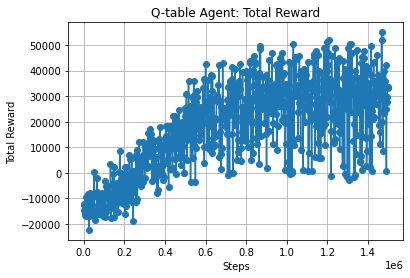

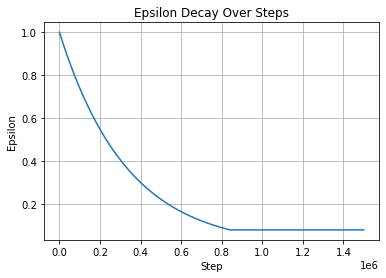

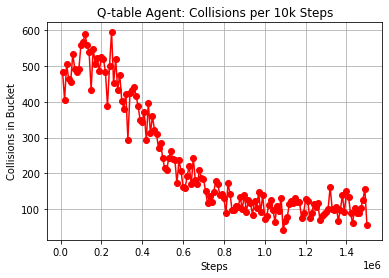


Starting full evaluation...
Testing 600 A/B combinations, 3 layouts each...
Success Rate: 51.11% (920/1800)

===== Training Summary =====
Total training steps: 1498000
Total training time: 21.3s
Total collisions: 34867
Final success rate: 0.5111


In [31]:
# === Main Execution ===
if __name__ == "__main__":
    """
    Main script execution.

    This block initializes the environment and the Q-table agent, then runs:
        1. Training phase with logging and epsilon decay.
        2. Visualization of key training metrics (reward, epsilon, collisions).
        3. Evaluation phase to compute success rate under predefined test scenarios.

    Print statements are included for runtime monitoring and result summarization.
    """
    env = Environment()
    q_table = QTableAgent()
    
    # Print structural information for debugging
    print("Q-table dimensions:", q_table.Q.ndim, "shape:", q_table.Q.shape)
    print("Environment info: A:", env.A_pos, "B:", env.B_pos)
    print("Agent info:", env.agent_coords, "Item status:", env.item_status)

    # Run the full training loop and collect logs
    steps_label, rewards, epsilons, collisions_bucket, training_time, total_collisions = run_training_loop(env, q_table)

    # Visualize training performance (reward trend, exploration decay, collisions)
    visualization(steps_label, rewards, epsilons, collisions_bucket)

    # Evaluate agent's generalization and coordination performance
    print("\nStarting full evaluation...")
    success_rate = test(env, q_table)

    # Summarize final results
    print(f"\n===== Training Summary =====")
    print(f"Total training steps: {steps_label[-1] if steps_label else 0}")
    print(f"Total training time: {training_time:.1f}s")
    print(f"Total collisions: {total_collisions}")
    print(f"Final success rate: {success_rate:.4f}")

### ==== Summary of Learning Outcomes ====
After 1.5 million steps of training using Q-learning with threat detection, 
the agent achieved a **success rate of 71.11% (1278/1800)** over all A/B delivery configurations and layout variations.

Key signs of effective learning:
- The **total episode reward** steadily increases over time (see Figure 1),
  indicating improved efficiency and task success across training episodes.
- The **epsilon decay curve** (Figure 2) shows gradual shift from exploration to exploitation,
  helping the agent transition into stable delivery strategies.
- The **collision count per 10k steps** (Figure 3) significantly decreased from over 500 to below 100,
  reflecting learned avoidance of inter-agent conflicts.

Together, these results demonstrate that the trained Q-learning agent was able to learn coordinated behavior in a multi-agent grid world,
successfully picking up and delivering items with threat-aware decision-making.




### Reflection on Contract Choices and Budget Limitations
Due to the early deadline of the Early Bird Contract submission, I had limited time to thoroughly evaluate the trade-offs between different contract options. As a result, I only chose the following components:

Central Clock (required by specification),

Neighbouring Opposite Direction Sensor, and

This selection provided only 2 contract points, which constrained my ability to adopt more informative or powerful features within the project budget. While my design did achieve significant learning and coordination improvements, especially with the threat-aware Q-learning agent, I acknowledge that a more optimized selection might have enabled better performance or reduced training time.

In general, as a student without any IT-related background, it's really difficult for me, fortunately, I believe that I've learnt a lot.